**4th European Conference on Social Networks**

**Workshop: Introduction to Python's Graph-Tool**
# graph-tool SBM - Generation

**Author**: <a href='https://marcosoliveira.info/'>Marcos Oliveira</a>, GESIS - Leibniz Institute for the Social Sciences

**Version**: 9 Sep 2019

**Description**: This is an introduction to stochastic block modelling in Python using the <code>graph-tool</code> library. 
    
## Imports and Settings

In [1]:
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np

<div class="alert alert-danger">
    You need the <code>graph_tool</code> library in your machine. Sometimes the installation is challenging. This <a href=https://git.skewed.de/count0/graph-tool/wikis/installation-instructions>page</a> might help you.
</div>

In [2]:
import graph_tool.all as gt
print(gt.__version__)

2.28 (commit e5760dfc, Thu Jun 6 15:14:05 2019 +0100)


<div class="alert alert-warning">
    If you running this notebook via the GESIS infrastructure, you should set the number of threads as the following; otherwise, it will be slow.
</div>

In [3]:
# gt.openmp_set_num_threads(2)

# The Stochastic Block Model

We generate networks using the standard stochastic block model (SBM) by defining the propensity matrix. In the canonical version, this matrix tell us the average number of edges between groups.

### Generating networks with assortative mixing.

Let's first create assortative networks using SBM. The following function creates the propensity matrix, given the number of nodes, groups, and the probability of connection intra- and inter-groups:

In [4]:
def generate_assortative_block_mix(nodes, groups, p_ii, p_ij):
    group_size = nodes / groups + nodes % groups
    membership = np.concatenate([np.repeat(g, group_size) for g in range(groups)])[:nodes]
    propensity = np.zeros([groups, groups])
    for i in range(groups):
        for j in range(groups):
            if i == j:
                propensity[i, j] = p_ii * group_size * group_size 
            else:
                propensity[i, j] = p_ij * group_size * group_size / 2    
    return membership, propensity

We create a network of 100 nodes and 5 groups which the intra-group connection probability is equal to $0.5$ and the inter group connection probability is equal to $0.01$: 

In [5]:
nodes, groups = 100, 5
p_ii, p_ij = 0.5, 0.01
group_memberships, propensity = generate_assortative_block_mix(nodes, groups, p_ii, p_ij)

In [6]:
group_memberships

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

In [7]:
propensity

array([[200.,   2.,   2.,   2.,   2.],
       [  2., 200.,   2.,   2.,   2.],
       [  2.,   2., 200.,   2.,   2.],
       [  2.,   2.,   2., 200.,   2.],
       [  2.,   2.,   2.,   2., 200.]])

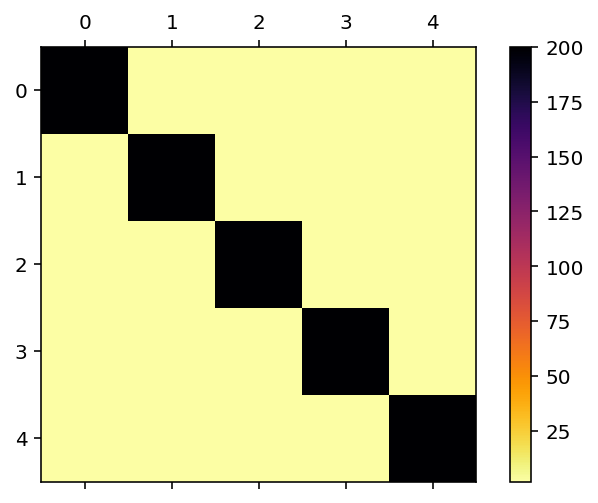

In [8]:
cax = plt.axes().matshow(propensity, cmap=plt.cm.inferno_r)
plt.colorbar(cax);

Most of the action happens in the <code>gt.<b>generate_sbm</b>()</code> function. 

<div class="alert alert-warning">
    Let's see the signature of the <code>generate_sbm</code> method:
    
- graph_tool.generation.<b>generate_sbm</b>(b, probs, out_degs=None, in_degs=None, directed=False, micro_ers=False, micro_degs=False)

Let's focus on <code>b</code> and <code>probs</code>:

- <code>b</code> is the group membership of each node; it is an iterable containing the label of each node. 
- <code>probs</code> is the matrix of propensity between groups. <code>probs[r,s]</code> is the average number of edges between groups r and s. 
</div>

In [9]:
g = gt.generate_sbm(group_memberships, propensity)

In [10]:
adjacency = gt.adjacency(g)

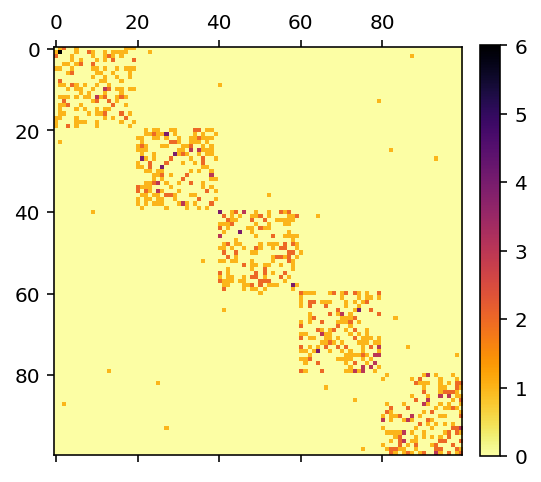

In [11]:
cax = plt.matshow(adjacency.todense(), cmap=plt.cm.inferno_r)
plt.colorbar(cax, fraction=0.046, pad=0.04);

We can remove self loops with the <code>gt.<b>remove_self_loops</b>(g)</code> function.

In [12]:
gt.remove_self_loops(g)

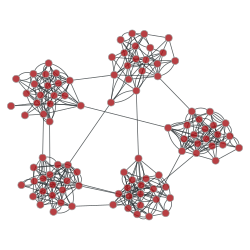

In [13]:
pos = gt.sfdp_layout(g)
gt.graph_draw(g, output_size=(250, 250));

In [14]:
def node_colors(g, group_memberships):
    """
        Given a graph and a group membership, this function returns 
        a vertex property with node color for each group.
    """
    colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6']
    to_rgb = lambda h: list(int(h[i:i+2], 16)/255. for i in (0, 2, 4))
    vertex_color = g.new_vertex_property('vector<double>')
    for m, v in zip(group_memberships, g.vertices()):
        vertex_color[g.vertex(v)] = tuple(to_rgb(colors[m][1:]) + [255.0])
    return vertex_color

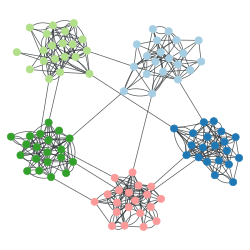

In [15]:
vertex_color = node_colors(g, group_memberships)
pos = gt.sfdp_layout(g)
gt.graph_draw(g, vertex_fill_color=vertex_color, vertex_color=vertex_color, output_size=(250, 250));

Let's change a bit our function to create blocks of different size:

In [16]:
def generate_assortative_block_mix(group_sizes, p_ii, p_ij):
    groups = len(group_sizes)
    membership = np.concatenate([
        np.repeat(i, g) for (i, g) in zip(range(groups), group_sizes)
    ])
    propensity = np.zeros([groups, groups])
    for i in range(groups):
        for j in range(groups):
            if i == j:
                propensity[i, j] = p_ii * group_sizes[i] * group_sizes[j] 
            else:
                propensity[i, j] = p_ij * group_sizes[i] * group_sizes[j] / 2.    
    return membership, propensity

In [17]:
group_sizes = [50, 20, 10, 10, 10]
group_memberships, propensity = generate_assortative_block_mix(group_sizes, 0.5, 0.01)

In [18]:
propensity

array([[1.25e+03, 5.00e+00, 2.50e+00, 2.50e+00, 2.50e+00],
       [5.00e+00, 2.00e+02, 1.00e+00, 1.00e+00, 1.00e+00],
       [2.50e+00, 1.00e+00, 5.00e+01, 5.00e-01, 5.00e-01],
       [2.50e+00, 1.00e+00, 5.00e-01, 5.00e+01, 5.00e-01],
       [2.50e+00, 1.00e+00, 5.00e-01, 5.00e-01, 5.00e+01]])

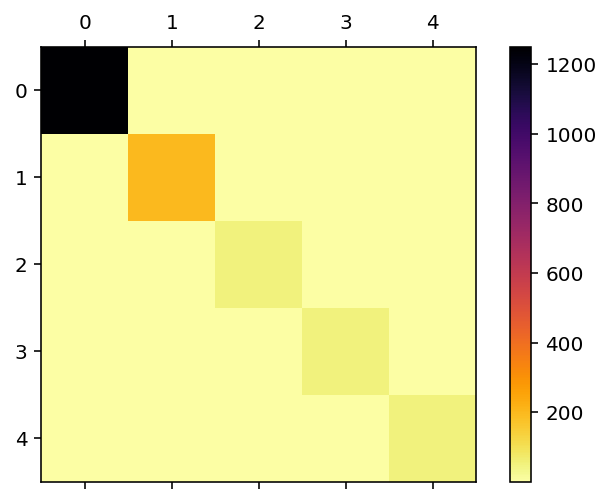

In [19]:
cax = plt.axes().matshow(propensity, cmap=plt.cm.inferno_r)
plt.colorbar(cax);

Then we generate a network:

In [20]:
g = gt.generate_sbm(group_memberships, propensity)

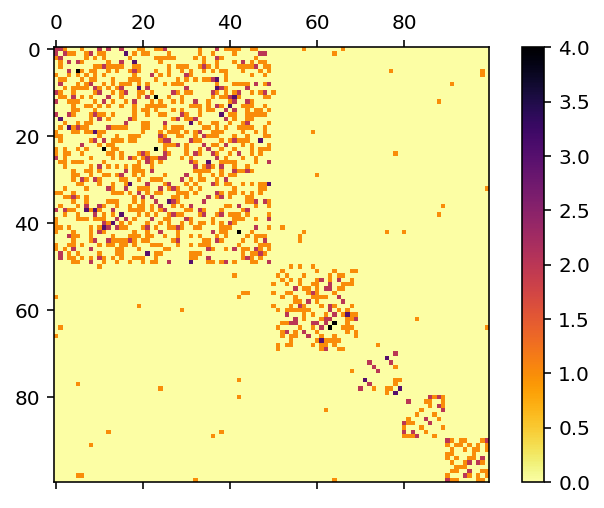

In [21]:
adjacency = gt.adjacency(g)
cax = plt.axes().matshow(adjacency.todense(), cmap=plt.cm.inferno_r)
plt.colorbar(cax);

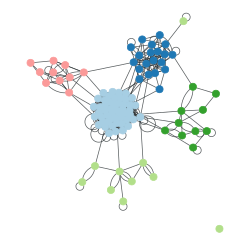

In [22]:
vertex_color = node_colors(g, group_memberships)
pos = gt.sfdp_layout(g)
gt.graph_draw(g, vertex_fill_color=vertex_color, vertex_color=vertex_color, output_size=(250, 250));

### Generating networks with disassortative mixing.

In [23]:
group_sizes = [50, 25, 25]
group_memberships, propensity = generate_assortative_block_mix(group_sizes, 0.01, 0.4)

In [24]:
propensity

array([[ 25.  , 250.  , 250.  ],
       [250.  ,   6.25, 125.  ],
       [250.  , 125.  ,   6.25]])

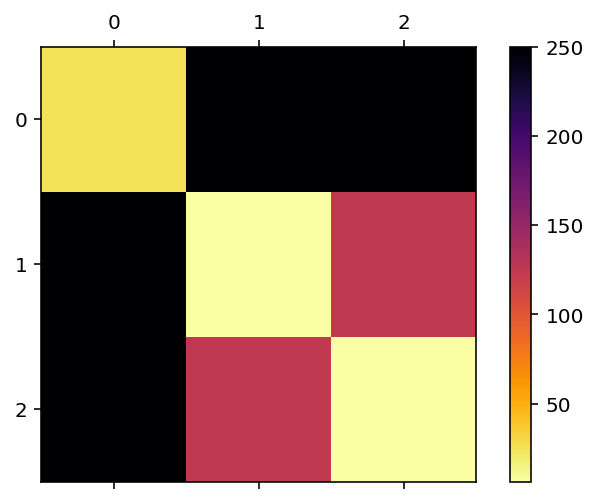

In [25]:
cax = plt.axes().matshow(propensity, cmap=plt.cm.inferno_r)
plt.colorbar(cax);

In [26]:
g = gt.generate_sbm(group_memberships, propensity)

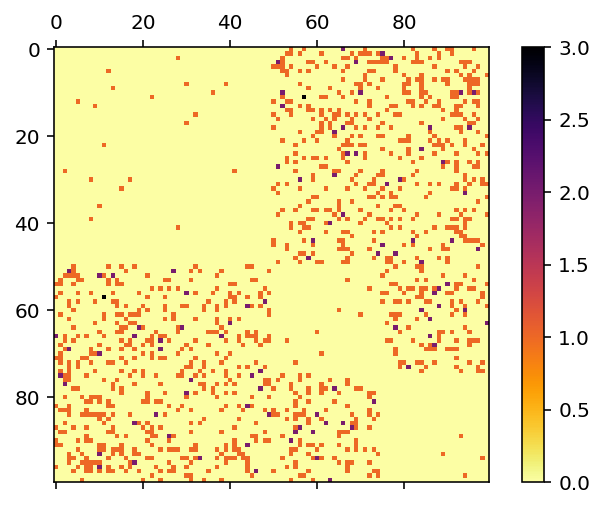

In [27]:
adjacency = gt.adjacency(g)
cax = plt.axes().matshow(adjacency.todense(), cmap=plt.cm.inferno_r)
plt.colorbar(cax);

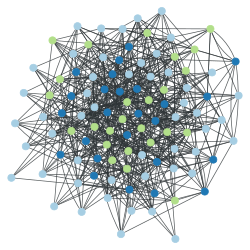

In [28]:
vertex_color = node_colors(g, group_memberships)
pos = gt.sfdp_layout(g)
gt.graph_draw(g, vertex_fill_color=vertex_color, vertex_color=vertex_color, output_size=(250, 250));

### An extreme case of heterophily:

In [29]:
group_sizes = [50, 50]
group_memberships, propensity = generate_assortative_block_mix(group_sizes, 0.0, 0.25)
g = gt.generate_sbm(group_memberships, propensity)

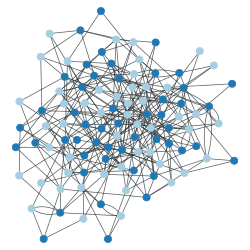

In [30]:
vertex_color = node_colors(g, group_memberships)
pos = gt.sfdp_layout(g)
gt.graph_draw(g, vertex_fill_color=vertex_color, vertex_color=vertex_color, output_size=(250, 250));

### Generating networks with core-periphery structure

In [31]:
probabilities = np.array([[.45, .15, .04],
                          [.15, .25, .05],
                          [.04, .05, .06]])

In [32]:
group_sizes = [25, 50, 75]
group_memberships, _ = generate_assortative_block_mix(group_sizes, 0.5, 0.01)

In [33]:
propensity = np.zeros_like(probabilities)
for i in range(len(group_sizes)):
    for j in range(len(group_sizes)):
        propensity[i][j] = probabilities[i][j]*group_sizes[i]*group_sizes[j]
        if i == j:
            propensity[i][j] /= 2.0

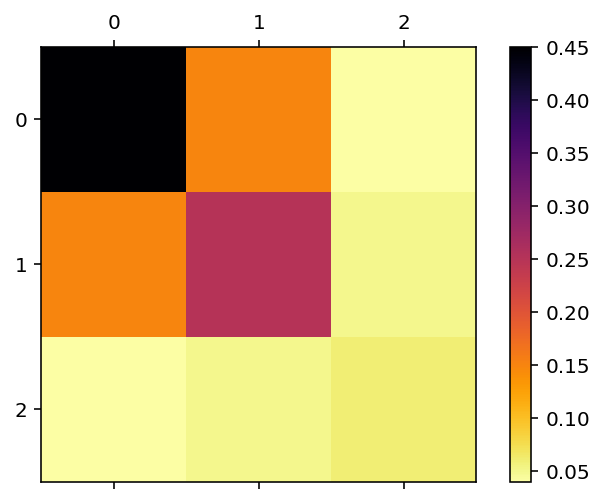

In [34]:
cax = plt.axes().matshow(probabilities, cmap=plt.cm.inferno_r)
plt.colorbar(cax);

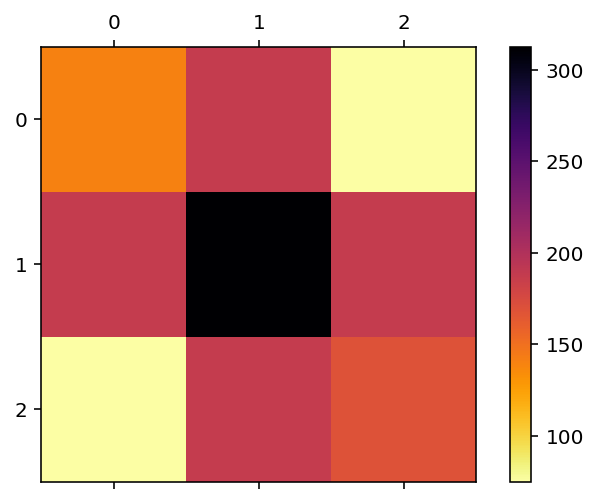

In [35]:
cax = plt.axes().matshow(propensity, cmap=plt.cm.inferno_r)
plt.colorbar(cax);

<div class="alert alert-info">
Did you notice that the two matrices above are different? Can you see why?
</div>

In [36]:
g = gt.generate_sbm(group_memberships, propensity)

Let's plot it:

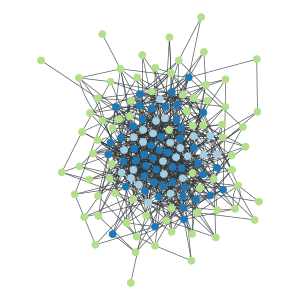

In [37]:
vertex_color = node_colors(g, group_memberships)
pos = gt.sfdp_layout(g)
gt.graph_draw(g, pos=pos, vertex_fill_color=vertex_color, vertex_color=vertex_color, output_size=(300, 300));

<div class="alert alert-info">
What networks are like this?
</div>

# Exercises

<div class="alert alert-success">
    <b>Exercise 1</b> 
    
In some social networks, the age of the individuals plays a main role, producing the so-called 'ordered communities'. Create the block matrix for this type of structure and generate networks using SBM.
</div>

<div class="alert alert-success">
    <b>Exercise 2</b> 
    
Construct a network with a multi-core-periphery structure using the SBM.

</div>

<div class="alert alert-success">
    <b>Exercise 3</b> 
    
Construct the following using the SBM:
<img src="images/sbm_hierarchy.png">

<b>Hint:</b> <code>gt.<b>remove_parallel_edges</b></code>
</div>
